# **Khởi tạo**

**Import thư viện**

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

**Xử lý dữ liệu**

In [102]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)

    return data

**Xây dựng mô hình**

In [103]:
def build_and_evaluate_model(file_name, train_ratio=0.7, test_ratio=0.2):
    # Đọc dữ liệu từ file CSV
    df = read_file(file_name)
    df1 = df.reset_index()['Price']
    # Scaler data
    scaler = MinMaxScaler(feature_range=(0,1))
    df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
    # Chia train, test
    train_size = int(train_ratio * len(df1))
    test_size = int(test_ratio * len(df1))
    train_data = df1[:train_size]
    test_data = df1[train_size:train_size+test_size]
    # Hàm Create Dataset
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    # Define LSTM Model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)
    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    # Đánh giá độ chính xác thuật toán bằng RMSE
    train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Train RMSE:', train_rmse)
    print('Testing RMSE:', test_rmse)
    # Dự báo 30 ngày tiếp theo
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < 30:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())

    # Vẽ hình
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))
    prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
    plt.legend(['Train','Test','Predict','Predict30days'])
    plt.show()

# **BIDV**

**BIDV 7:3**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1127 
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010    
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010    
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5864e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6200e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7638e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2340e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss

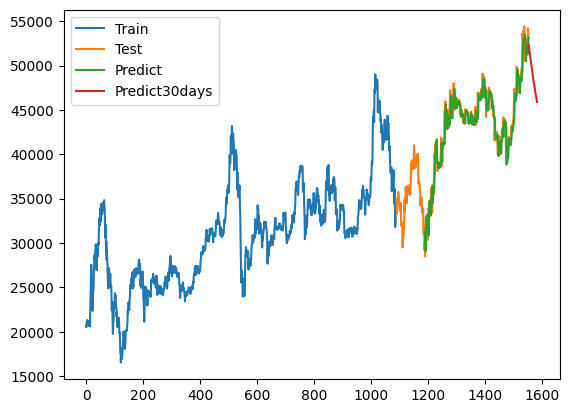

In [104]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3)

**BIDV 8:2**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0817  
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 16/100
1

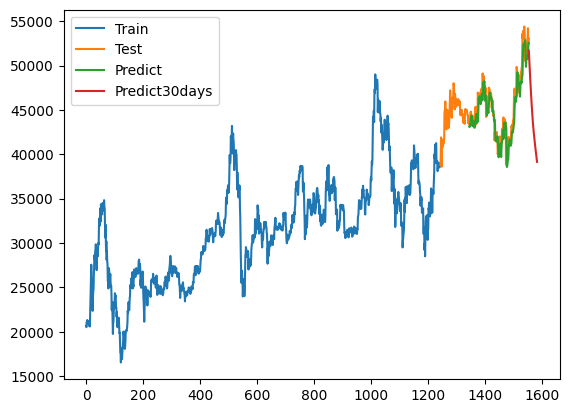

In [105]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2)

**BIDV 9:1**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0781
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6369e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0451e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9797e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6199e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9224e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1383e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3082e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4335e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8751e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3867e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 

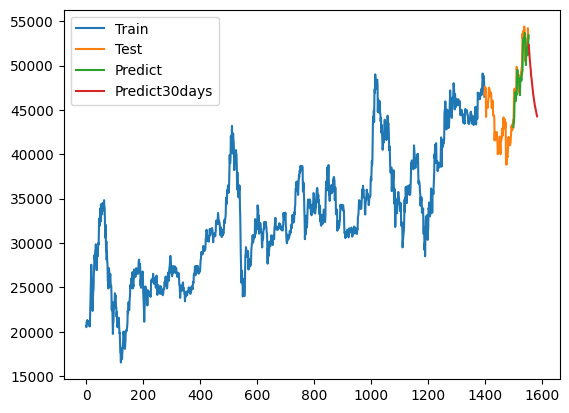

In [106]:
build_and_evaluate_model('../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1)

# **MBB**

**MBB 7:3**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0234  
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1882e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4700e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4701e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1605e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6105e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9164e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8864e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6661e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6493e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5850e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0

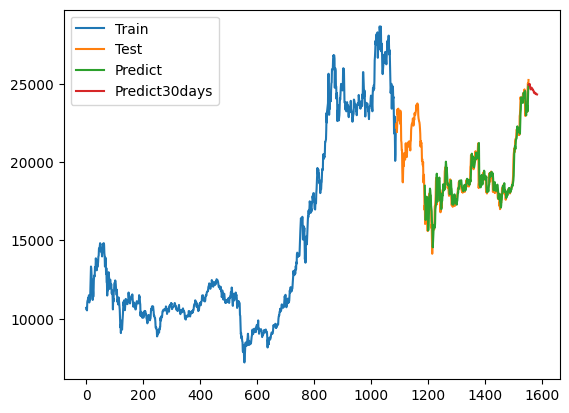

In [107]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3)

**MBB 8:2**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0478
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8448e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0636e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5408e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9018e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5648e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1536e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3993e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4643e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3651e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4023e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9430e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2616e-04
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━

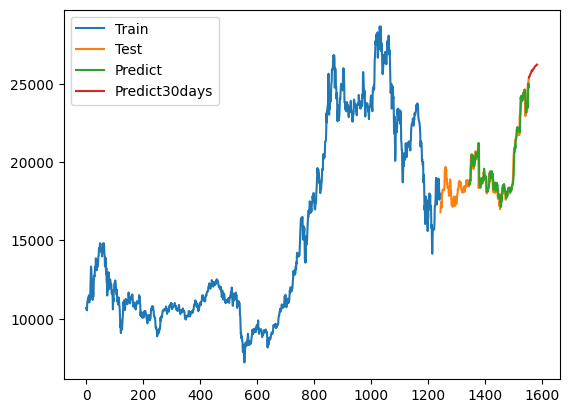

In [108]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2)

**MBB 9:1**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1838  
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6078e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6543e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6780e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7593e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4498e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6753e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0894e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1243e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6892e-04
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8313e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7860e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━

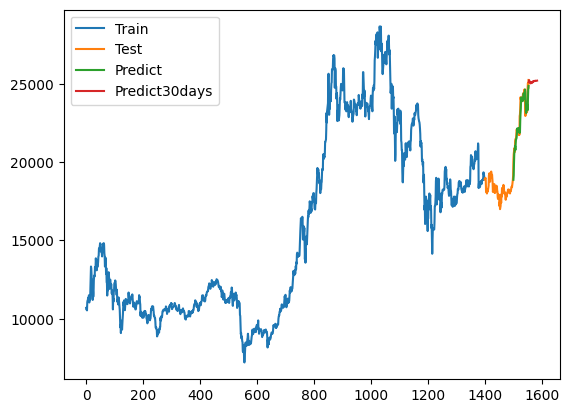

In [109]:
build_and_evaluate_model('../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1)

# **VCB**

**VCB 7:3**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0823 
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7652e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.6809e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0264e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7544e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6986e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4348e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2048e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4936e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1646e-04
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10

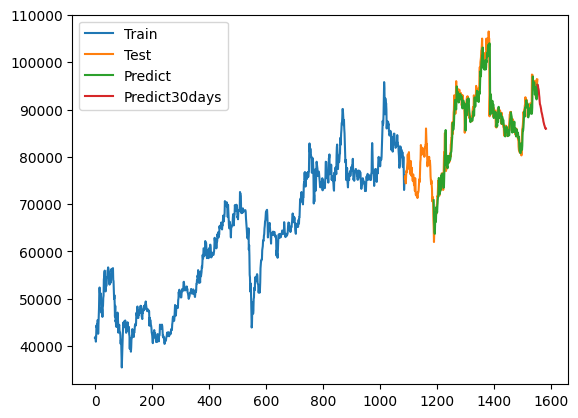

In [110]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3)

**VCB 8:2**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1455  
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012   
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012   
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010    
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.00

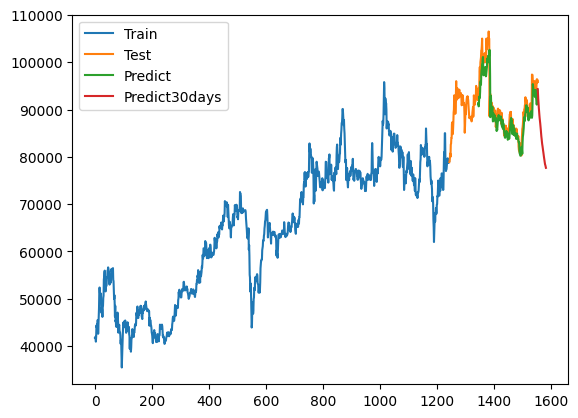

In [111]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2)

**VCB 9:1**

Epoch 1/100


c:\Users\DUONG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0573 
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011  
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5970e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.4070e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6012e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0116e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7921e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5576e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5026e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3996e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6538e-04 
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7399e-04
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3466e-04
Epoch 15/100
21/21 ━━━━━━━━━━━━━

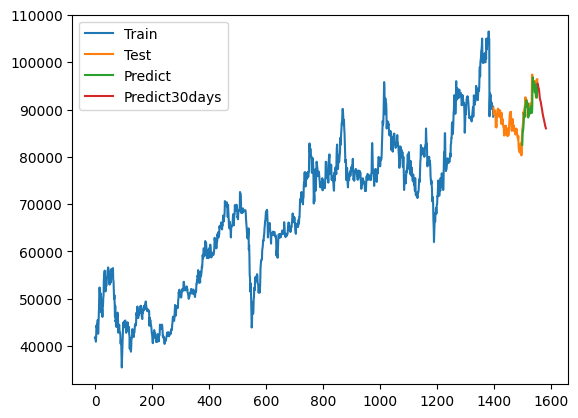

In [112]:
build_and_evaluate_model('../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1)